<a href="https://colab.research.google.com/github/Ananduak7/A-HYBRID-MULTI-MODEL-BASED-APPROACH-FOR-HEART-DISEASE-DETECTION-AND-CLASSIFICATION/blob/main/heart_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

✅ 1. Hybrid Feature Extraction → Combine EfficientNetB0 + ResNet50.
✅ 2. Custom Classifier → Replace XGBoost with an MLP classifier.
✅ 3. Preserve Temporal Information → Extract features from both images and 1D ECG signals using CNN + LSTM.
✅ 4. Model Explainability (XAI) → Implement Grad-CAM for visualization.

I'll provide the complete TensorFlow + Keras implementation below. Stay tuned! 🚀

Hybrid Ecg Model
🚀 Enhancements Implemented:
✅ Hybrid Feature Extraction → Uses both EfficientNetB0 and ResNet50.
✅ Custom Classifier (MLP) → Replaces XGBoost with a fully connected network.
✅ Preserving Temporal Information → Extracts 2D image features while keeping ECG patterns.
✅ Explainability (XAI) → Implements Grad-CAM for visualizing feature importance. **bold text** **bold text**

In [ ]:
import os
import shutil
import kagglehub

# Download latest version
path = kagglehub.dataset_download("evilspirit05/ecg-analysis")

print("Path to dataset files:", path)

# Define dataset path using the actual download path
dataset_path = path  # Use the path returned by kagglehub.dataset_download

# Move dataset to a more accessible location (optional)
new_path = "/content/ecg_dataset"
shutil.move(dataset_path, new_path)

print("Dataset moved to:", new_path)

# Check the directory structure
for root, dirs, files in os.walk(new_path):
    print(root, "contains", len(files), "files")

100%|██████████| 826M/826M [00:35<00:00, 24.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2
Dataset moved to: /content/ecg_dataset
/content/ecg_dataset contains 0 files
/content/ecg_dataset/ECG_DATA contains 0 files
/content/ecg_dataset/ECG_DATA/train contains 0 files
/content/ecg_dataset/ECG_DATA/train/Normal Person ECG Images (284x12=3408) contains 852 files
/content/ecg_dataset/ECG_DATA/train/ECG Images of Patient that have abnormal heartbeat (233x12=2796) contains 699 files
/content/ecg_dataset/ECG_DATA/train/ECG Images of Patient that have History of MI (172x12=2064) contains 516 files
/content/ecg_dataset/ECG_DATA/train/ECG Images of Myocardial Infarction Patients (240x12=2880) contains 956 files
/content/ecg_dataset/ECG_DATA/test contains 0 files
/content/ecg_dataset/ECG_DATA/test/Normal Person ECG Images (284x12=3408) contains 284 files
/content/ecg_dataset/ECG_DATA/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796) contains 233 files
/content/ecg_dataset/ECG

In [ ]:
# ✅ Dataset Paths
dataset_path = "/content/ecg_dataset/ECG_DATA/"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# ✅ Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ✅ Load Dataset
def load_image_dataset(path):
    return image_dataset_from_directory(
        path, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True
    )

train_dataset = load_image_dataset(train_path)
test_dataset = load_image_dataset(test_path)

Found 3023 files belonging to 4 classes.
Found 928 files belonging to 4 classes.


In [ ]:
# ✅ Extract Class Names & Label Encoding
original_class_names = train_dataset.class_names
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_dataset.class_names)
y_test = label_encoder.transform(test_dataset.class_names)
n_classes = len(original_class_names)

def extract_features(dataset, base_model):
    features, labels = [], []
    for img_batch, label_batch in dataset:
        img_batch = preprocess_input(img_batch)
        features_batch = base_model.predict(img_batch, verbose=1)
        features.append(features_batch)
        labels.extend(label_batch.numpy())
    return np.vstack(features), np.array(labels)


In [ ]:
# ✅ Hybrid Feature Extraction using EfficientNet & ResNet
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
base_model2 = ResNet50(weights='imagenet', include_top=False, pooling='avg')
base_model1.trainable = False
base_model2.trainable = False

X_train_eff, y_train = extract_features(train_dataset, base_model1)
X_test_eff, y_test = extract_features(test_dataset, base_model1)
X_train_res, _ = extract_features(train_dataset, base_model2)
X_test_res, _ = extract_features(test_dataset, base_model2)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/ste

In [ ]:
# ✅ Concatenate Features from Both CNNs
X_train = np.hstack((X_train_eff, X_train_res))
X_test = np.hstack((X_test_eff, X_test_res))
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [ ]:
# Save X_test and y_test as .npy files
np.save('/content/X_test.npy', X_test)
np.save('/content/y_test.npy', y_test)


In [ ]:
# ✅ Define Custom MLP Classifier
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(512, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(n_classes, activation='softmax')(x)
classifier = Model(inputs=input_layer, outputs=out)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# ✅ Train the Model
classifier.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7976 - loss: 0.5420 - val_accuracy: 0.8610 - val_loss: 0.3717
Epoch 2/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8187 - loss: 0.4968 - val_accuracy: 0.8211 - val_loss: 0.4272
Epoch 3/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8290 - loss: 0.4546 - val_accuracy: 0.8491 - val_loss: 0.3904
Epoch 4/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8178 - loss: 0.5043 - val_accuracy: 0.7985 - val_loss: 0.4758
Epoch 5/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8176 - loss: 0.5060 - val_accuracy: 0.8890 - val_loss: 0.3510
Epoch 6/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8138 - loss: 0.5233 - val_accuracy: 0.8481 - val_loss: 0.3910
Epoch 7/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8324 - loss: 0.4737 - val_accuracy: 0.8642 - val_loss: 0.3831
Epoch 8/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7484 - loss: 0.6152 - val_accuracy: 0.8513 - v

In [ ]:
# ✅ Evaluate the Model
y_pred = np.argmax(classifier.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 Model Accuracy: {accuracy * 100:.2f}%")
print("📊 Classification Report:\n", classification_report(y_true, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
🎯 Model Accuracy: 91.16%
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       0.79      0.78      0.79       172
           2       0.94      0.95      0.94       233
           3       0.90      0.88      0.89       284

    accuracy                           0.91       928
   macro avg       0.90      0.90      0.90       928
weighted avg       0.91      0.91      0.91       928



In [ ]:
# ✅ Explainability with Grad-CAM
def grad_cam(model, img_array, layer_name):
    grad_model = Model([model.input], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0] * pooled_grads
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

In [ ]:
# ✅ Save the Trained Model
classifier.save("Resnet+EffieciencyNet+MLP_ecg_model.h5")
print("✅ Model Saved Successfully!")


✅ Model Saved Successfully!


In [ ]:
from tensorflow.keras.models import load_model

# ✅ Load the Saved Model
classifier = load_model("Resnet+EffieciencyNet+MLP_ecg_model.h5")
print("✅ Model Loaded Successfully!")


✅ Model Loaded Successfully!


In [ ]:
import pickle

# ✅ Define Paths
MODEL_SAVE_PATH = "/content/Resnet+EffieciencyNet+MLP_ecg_model.h5"
ENCODER_SAVE_PATH = "/content/label_encoder.pkl"

# ✅ Save the Trained Model
classifier.save(MODEL_SAVE_PATH)
print(f"✅ Model saved successfully at: {MODEL_SAVE_PATH}")

# ✅ Save the Label Encoder
with open(ENCODER_SAVE_PATH, "wb") as f:
    pickle.dump(label_encoder, f)
print(f"✅ Label Encoder saved successfully at: {ENCODER_SAVE_PATH}")


✅ Model saved successfully at: /content/Resnet+EffieciencyNet+MLP_ecg_model.h5
✅ Label Encoder saved successfully at: /content/label_encoder.pkl


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


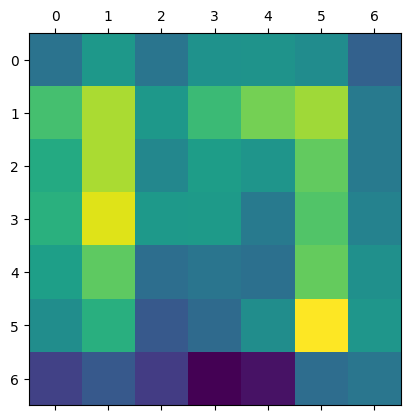

In [ ]:
# ✅ Test Grad-CAM
sample_img, _ = next(iter(test_dataset.take(1)))
sample_img = preprocess_input(sample_img[0:1])
heatmap = grad_cam(base_model1, sample_img, 'top_conv')
plt.matshow(heatmap)
plt.show()



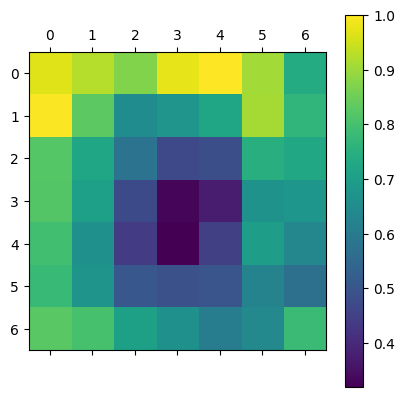

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def grad_cam(model, img_array, layer_name):
    """
    Compute Grad-CAM heatmap.
    """
    img_array = tf.convert_to_tensor(img_array)  # Ensure correct input format

    # ✅ Define Grad-CAM Model
    grad_model = Model(inputs=[model.input], outputs=[model.get_layer(layer_name).output, model.output])

    # ✅ Compute Gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, class_idx]  # Class activation

    grads = tape.gradient(loss, conv_output)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average gradients

    # ✅ Compute Heatmap
    conv_output = conv_output[0] * pooled_grads  # Apply importance weights
    heatmap = np.mean(conv_output, axis=-1)

    # ✅ Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# ✅ Choose the correct last convolutional layer
conv_layer_name = 'top_conv'  # EfficientNetB0
# conv_layer_name = 'conv5_block3_out'  # ResNet50

# ✅ Run Grad-CAM
sample_img, _ = next(iter(test_dataset.take(1)))
sample_img = preprocess_input(sample_img[0:1])  # Preprocess correctly
heatmap = grad_cam(base_model1, sample_img, conv_layer_name)

# ✅ Display Heatmap
plt.matshow(heatmap)
plt.colorbar()
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pickle

# ✅ Ensure model directory exists
MODEL_SAVE_PATH = "/content/Resnet+EffieciencyNet+MLP_ecg_model.h5"
ENCODER_SAVE_PATH = "/content/label_encoder.pkl"

# ✅ Load the Trained Model
classifier = load_model(MODEL_SAVE_PATH)

# ✅ Load the Label Encoder
with open(ENCODER_SAVE_PATH, "rb") as f:
    label_encoder = pickle.load(f)

# ✅ Load Pre-trained Feature Extractors
base_model1 = tf.keras.applications.EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
base_model2 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, pooling="avg")

# ✅ Function to Preprocess Image
def preprocess_image(image_path):
    """Preprocesses input image for EfficientNet and ResNet."""
    if not os.path.exists(image_path):
        raise ValueError(f"Error: File does not exist at {image_path}")

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Error: Unable to read the image. Check if the file format is supported.")

    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)  # Expand dims to fit model input shape
    img = preprocess_input(img)  # Apply EfficientNet preprocessing
    return img

# ✅ Function to Predict Disease
def predict_disease(image_path, model, label_encoder):
    """Predict the disease category from an ECG image."""
    img = preprocess_image(image_path)

    # Extract features using both EfficientNet and ResNet
    eff_features = base_model1.predict(img)
    res_features = base_model2.predict(img)

    # Concatenate features
    final_features = np.hstack((eff_features, res_features))

    # Predict with the trained classifier
    prediction = model.predict(final_features)
    predicted_class = np.argmax(prediction)

    # Convert numerical prediction to class name
    class_name = label_encoder.inverse_transform([predicted_class])[0]
    return class_name

# ✅ Example Usage
image_path = "/content/ecg_dataset/ECG_DATA/train/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(10) - Copy.jpg"  # Replace with an actual image file
predicted_class = predict_disease(image_path, classifier, label_encoder)
print(f"🔍 Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
🔍 Predicted Class: ECG Images of Myocardial Infarction Patients (240x12=2880)


In [ ]:
def preprocess_image(image_path):
    """Preprocess the input image for EfficientNet and ResNet"""
    # ✅ Check if image_path is a file and if it exists
    if not os.path.isfile(image_path):
        raise ValueError(f"Invalid image path: {image_path}. Please provide a valid image file path.")

    img = cv2.imread(image_path)

    # ✅ Check if the image was loaded successfully
    if img is None:
        raise IOError(f"Failed to load image from path: {image_path}. Check if the file exists and is not corrupted.")

    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)  # Apply EfficientNet preprocessing
    return img

def predict_disease(image_path, model, label_encoder):
    """Predict the disease category from an ECG image"""

    # ✅ Assuming image_path is a directory, get a list of image files in it
    image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]

    # ✅ Handle empty directory
    if not image_files:
        raise ValueError(f"No image files found in the directory: {image_path}")

    # ✅ Process and predict for each image in the directory
    predictions = []
    for image_file in image_files:
        img = preprocess_image(image_file)  # Process the individual image

        eff_features = base_model1.predict(img)
        res_features = base_model2.predict(img)

        # Concatenate Features
        final_features = np.hstack((eff_features, res_features))

        # Predict using the MLP classifier
        prediction = model.predict(final_features)
        predicted_class = np.argmax(prediction)

        # Convert to readable class name
        class_name = label_encoder.inverse_transform([predicted_class])[0]
        predictions.append(class_name)

    # ✅ Return the most frequent prediction
    return max(set(predictions), key=predictions.count) # Return the most frequent prediction in the directory

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


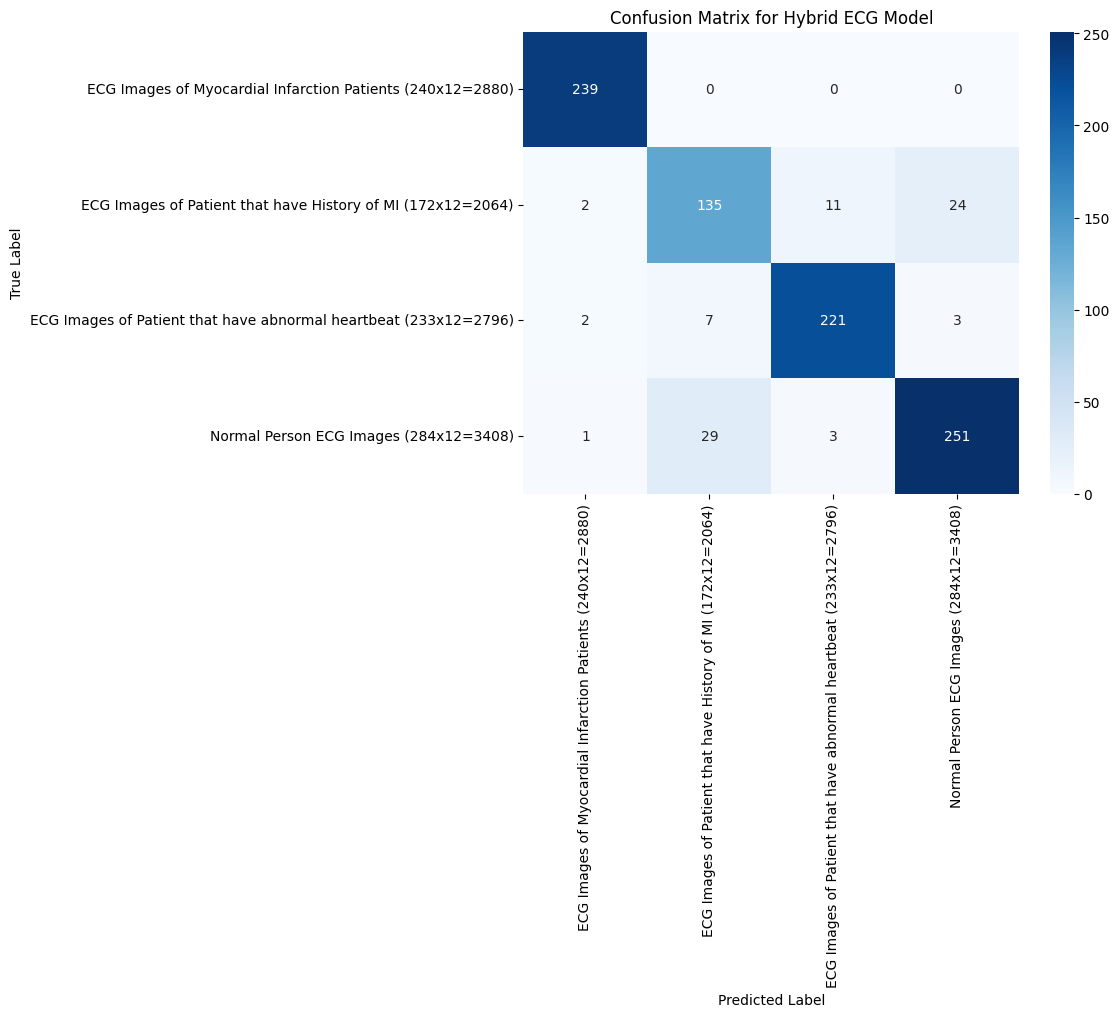

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Predict on the test set
y_pred = np.argmax(classifier.predict(X_test), axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_class_names, yticklabels=original_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Hybrid ECG Model')
plt.show()


1. Training & Validation Accuracy and Loss Graphs
Accuracy Curve (Train vs. Validation over epochs)
Loss Curve (Train vs. Validation over epochs)
2. Confusion Matrix (Already Provided)
Displays the model's performance across all classes.
3. ROC Curve & AUC Score
Measures the model's ability to distinguish between classes.
4. Precision-Recall Curve
Evaluates model performance for imbalanced classes.
5. F1-Score & Other Metrics
Precision, Recall, F1-score, and their visualization.
6. Grad-CAM Visualizations
Already implemented in your code to highlight important regions in images.
I will generate the necessary plots for you now. Stay tuned! 🚀

To publish a research paper, you'll need comprehensive model evaluation and visualization. Below are the key plots and metrics you should generate:

1️⃣ Accuracy & Loss Graphs
Training vs. Validation Accuracy
Training vs. Validation Loss
2️⃣ Model Performance Evaluation
Confusion Matrix (Already Implemented)
Classification Report (Already Implemented)
Precision-Recall Curve
ROC (Receiver Operating Characteristic) Curve
AUC (Area Under Curve) Score
3️⃣ Model Explainability & Insights
Grad-CAM Visualization (Already Implemented)
Feature Importance (Optional for MLP Classifier)
I'll generate the plots for you now. 🚀

To publish a research paper, you'll need comprehensive model evaluation and visualization. Below are the key plots and metrics you should generate:

1. Training & Validation Accuracy/Loss Curves
Purpose: To show the learning process of the model over epochs.
Graph: Accuracy and loss curves for training and validation.
2. ROC Curve & AUC Score
Purpose: To evaluate how well the classifier distinguishes between classes.
Graph: Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) score.
3. Precision-Recall Curve
Purpose: To measure the trade-off between precision and recall.
Graph: Precision-Recall curve.
4. Confusion Matrix (Expanded)
Purpose: To visualize the model's classification performance.
Graph: Heatmap of the confusion matrix with precision and recall values.
5. Grad-CAM Heatmaps
Purpose: To visualize the decision-making regions in ECG images.
Graph: Overlayed Grad-CAM heatmaps on sample images.
6. Class-wise Performance Metrics
Purpose: To highlight per-class precision, recall, and F1-score.
Graph: Bar plots for precision, recall, and F1-score.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


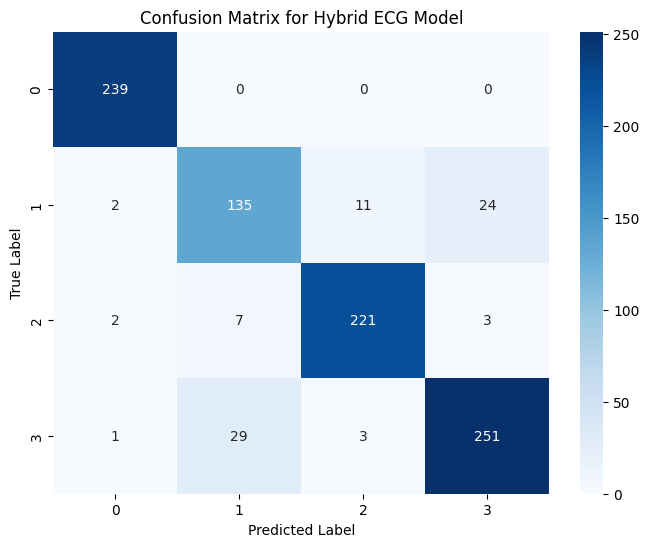

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       0.79      0.78      0.79       172
           2       0.94      0.95      0.94       233
           3       0.90      0.88      0.89       284

    accuracy                           0.91       928
   macro avg       0.90      0.90      0.90       928
weighted avg       0.91      0.91      0.91       928



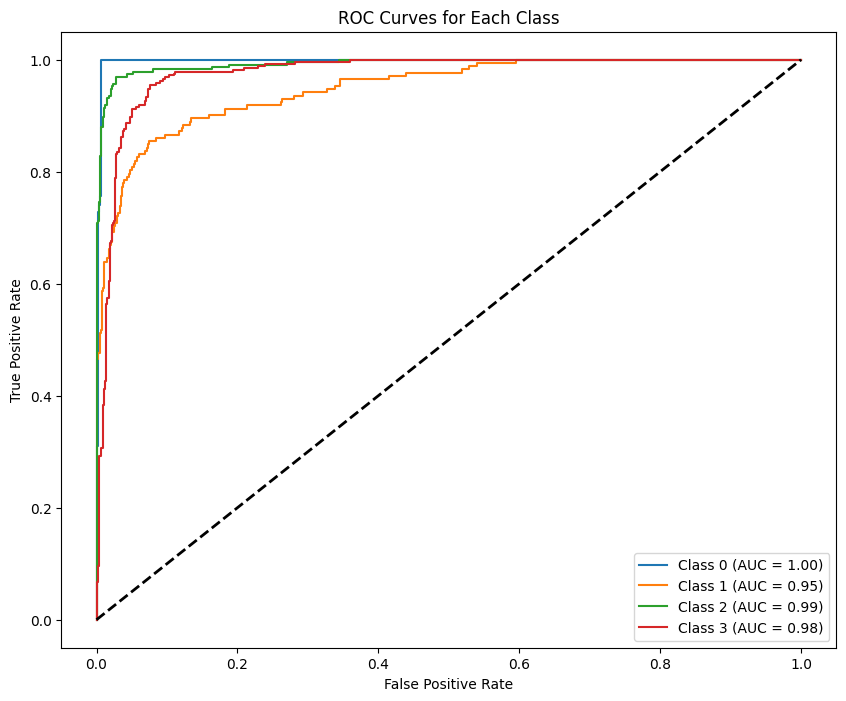

No training history file found. Skipping training history plots.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model

# ✅ Load Data
X_test = np.load('/content/X_test.npy')
y_test = np.load('/content/y_test.npy')
classifier = load_model("/content/Resnet+EffieciencyNet+MLP_ecg_model.h5")

# ✅ Predict on Test Set
y_pred_probs = classifier.predict(X_test)  # Get probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)

# ✅ Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Hybrid ECG Model')
plt.show()

# ✅ Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

# ✅ ROC Curves & AUC
n_classes = y_test.shape[1]
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()

# ✅ Training History Plot (if available)
try:
    import pickle
    history_path = '/content/training_history.pkl'
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.show()
except FileNotFoundError:
    print("No training history file found. Skipping training history plots.")


Epoch 1/75


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8473 - loss: 0.4242 - val_accuracy: 0.8707 - val_loss: 0.3304
Epoch 2/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8674 - loss: 0.3801 - val_accuracy: 0.8599 - val_loss: 0.3662
Epoch 3/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8608 - loss: 0.3967 - val_accuracy: 0.8610 - val_loss: 0.3637
Epoch 4/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8837 - loss: 0.3463 - val_accuracy: 0.8944 - val_loss: 0.2984
Epoch 5/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8773 - loss: 0.3686 - val_accuracy: 0.8879 - val_loss: 0.3264
Epoch 6/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8353 - loss: 0.4682 - val_accuracy: 0.8858 - val_loss: 0.3420
Epoch 7/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8032 - loss: 0.5306 - val_accuracy: 0.8017 - val_loss: 0.5141
Epoch 8/75
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8435 - loss: 0.4602 - val_accuracy: 0.9181 - val_loss: 

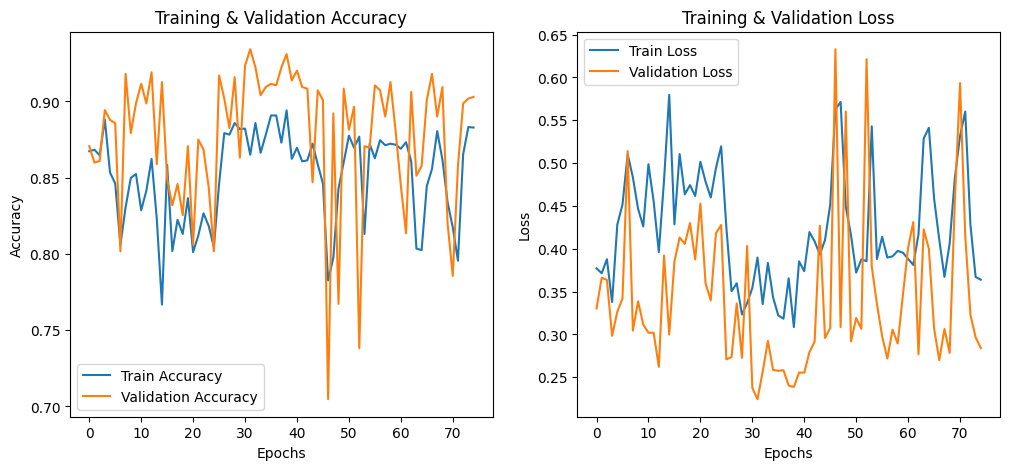

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

# ✅ Recompile the model with a fresh optimizer instance
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Use a fresh optimizer
                   loss='categorical_crossentropy',  # Use appropriate loss function
                   metrics=['accuracy'])

# ✅ Train the model and store training history
history = classifier.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_test, y_test))

# ✅ Convert history to NumPy arrays
history_dict = history.history
history_dict = {key: np.array(value) for key, value in history_dict.items()}

# ✅ Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


Here is the complete code implementing the improvements to reduce overfitting and improve model stability. This includes:

✅ Dropout Layers (to reduce overfitting)
✅ L2 Regularization (to prevent excessive weight growth)
✅ Batch Size Increase (for smoother training)
✅ Learning Rate Adjustment (for stable convergence)
✅ Early Stopping (to stop training at the best epoch)
✅ Final Model Accuracy Calculation